In [8]:
import pandas as pd

# Load the datasets
train = pd.read_csv('walmart_sales_data/train.csv')
features = pd.read_csv('walmart_sales_data/features.csv')
stores = pd.read_csv('walmart_sales_data/stores.csv')

# Merge train with stores
df = pd.merge(train, stores, on='Store', how='left')

# Merge with features
df = pd.merge(df, features, on=['Store', 'Date', 'IsHoliday'], how='left')

# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Display basic info
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Type          421570 non-null  object        
 6   Size          421570 non-null  int64         
 7   Temperature   421570 non-null  float64       
 8   Fuel_Price    421570 non-null  float64       
 9   MarkDown1     150681 non-null  float64       
 10  MarkDown2     111248 non-null  float64       
 11  MarkDown3     137091 non-null  float64       
 12  MarkDown4     134967 non-null  float64       
 13  MarkDown5     151432 non-null  float64       
 14  CPI           421570 non-null  float64       
 15  Unemployment  421

In [3]:
# Check for missing values
missing = df.isnull().sum()
print("Missing values:\n", missing[missing > 0])

# Fill missing Temperature, Fuel_Price, CPI, Unemployment using forward fill (or other logic if needed)
df[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']] = df[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].ffill()

# Check again to ensure no NaNs in key columns
print("\nAfter filling:")
print(df[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].isnull().sum())


Missing values:
 MarkDown1    270889
MarkDown2    310322
MarkDown3    284479
MarkDown4    286603
MarkDown5    270138
dtype: int64

After filling:
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


In [4]:
# Extract time-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
df['Day'] = df['Date'].dt.day

# Sort for lag creation
df = df.sort_values(by=['Store', 'Dept', 'Date'])

# Create lag features: previous week's sales
df['Sales_Lag_1'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
df['Sales_Lag_2'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(2)
df['Sales_Lag_3'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(3)

# Drop rows with NaN lag values (first few entries per group)
df = df.dropna(subset=['Sales_Lag_1', 'Sales_Lag_2', 'Sales_Lag_3'])

# Confirm
print(df[['Date', 'Store', 'Dept', 'Weekly_Sales', 'Sales_Lag_1', 'Sales_Lag_2', 'Sales_Lag_3']].head())


        Date  Store  Dept  Weekly_Sales  Sales_Lag_1  Sales_Lag_2  Sales_Lag_3
3 2010-02-26      1     1      19403.54     41595.55     46039.49     24924.50
4 2010-03-05      1     1      21827.90     19403.54     41595.55     46039.49
5 2010-03-12      1     1      21043.39     21827.90     19403.54     41595.55
6 2010-03-19      1     1      22136.64     21043.39     21827.90     19403.54
7 2010-03-26      1     1      26229.21     22136.64     21043.39     21827.90


In [5]:
# Sort the full DataFrame by date (just in case)
df = df.sort_values('Date')

# Define cutoff date for train/test
# Let's say we'll use data before July 2012 for training, and after for testing
cutoff_date = pd.to_datetime("2012-07-01")

# Create train/test splits
train_df = df[df['Date'] < cutoff_date]
test_df = df[df['Date'] >= cutoff_date]

# Check shapes
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Confirm
print("Train Date Range:", train_df['Date'].min(), "to", train_df['Date'].max())
print("Test Date Range:", test_df['Date'].min(), "to", test_df['Date'].max())


Train shape: (361384, 23)
Test shape: (50297, 23)
Train Date Range: 2010-02-26 00:00:00 to 2012-06-29 00:00:00
Test Date Range: 2012-07-06 00:00:00 to 2012-10-26 00:00:00


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define features (drop non-numeric/categorical)
features = [
    'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
    'IsHoliday', 'Type', 'Size',
    'Year', 'Month', 'Week',
    'Sales_Lag_1', 'Sales_Lag_2', 'Sales_Lag_3'
]

# Convert categorical 'Type' to numeric
train_df = train_df.copy()
test_df = test_df.copy()
train_df['Type'] = train_df['Type'].astype('category').cat.codes
test_df['Type'] = test_df['Type'].astype('category').cat.codes

# Define train and test sets
X_train = train_df[features]
y_train = train_df['Weekly_Sales']
X_test = test_df[features]
y_test = test_df['Weekly_Sales']

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred_lr)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_lr)
r2 = r2_score(y_test, y_pred_lr)

# Print results
print(f"Linear Regression Results:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R^2 Score: {r2:.4f}")


Linear Regression Results:
RMSE: 3374.82
MAE: 1645.60
R^2 Score: 0.9764


In [10]:
import xgboost as xgb

# Initialize model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Print results
print(f"XGBoost Results:")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"MAE: {mae_xgb:.2f}")
print(f"R^2 Score: {r2_xgb:.4f}")


XGBoost Results:
RMSE: 3150.50
MAE: 1427.24
R^2 Score: 0.9794


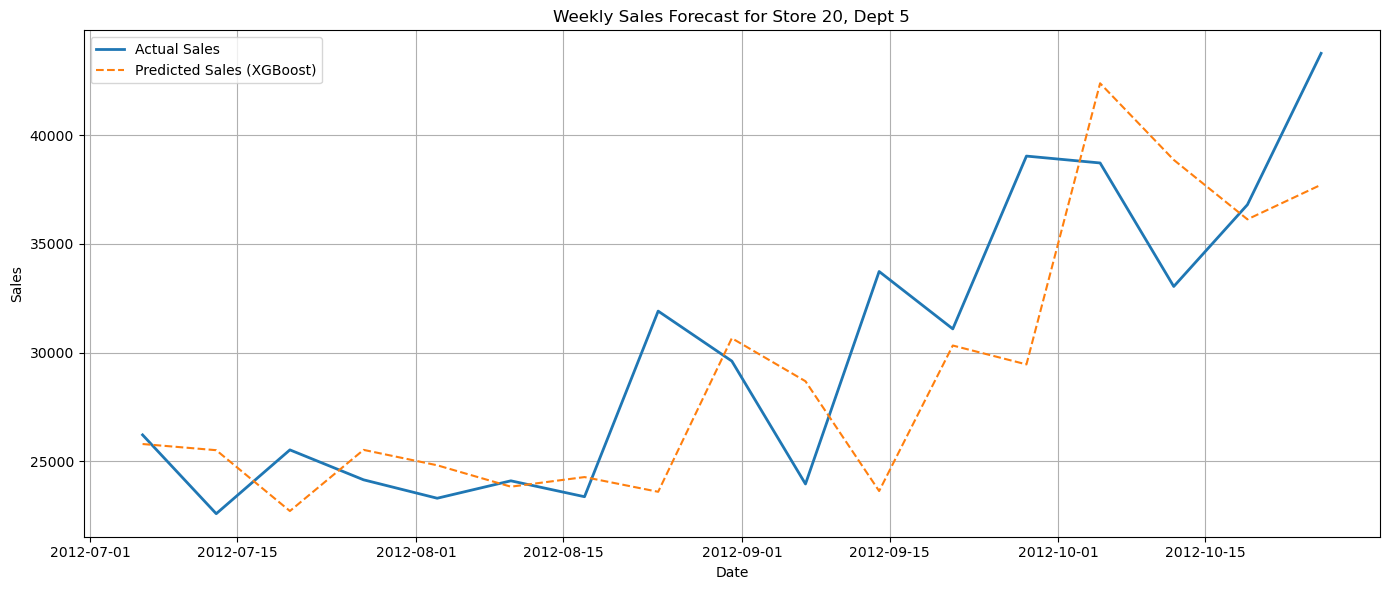

In [17]:
import matplotlib.pyplot as plt

# Create DataFrame to compare actual vs predicted
comparison_df = test_df.copy()
comparison_df['Predicted_Sales'] = y_pred_xgb

# Sort by date for smooth plotting
comparison_df = comparison_df.sort_values('Date')

# Plot actual vs predicted for a single store and department
#change dept and store to get related results 
sample_store = 20
sample_dept = 5

sample_data = comparison_df[(comparison_df['Store'] == sample_store) & (comparison_df['Dept'] == sample_dept)]

plt.figure(figsize=(14, 6))
plt.plot(sample_data['Date'], sample_data['Weekly_Sales'], label='Actual Sales', linewidth=2)
plt.plot(sample_data['Date'], sample_data['Predicted_Sales'], label='Predicted Sales (XGBoost)', linestyle='--')
plt.title(f'Weekly Sales Forecast for Store {sample_store}, Dept {sample_dept}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
# Total number of unique stores
num_stores = df['Store'].nunique()
print(f"Total unique Stores: {num_stores}")

# Total number of unique departments
num_depts = df['Dept'].nunique()
print(f"Total unique Departments: {num_depts}")


Total unique Stores: 45
Total unique Departments: 81


In [18]:
# Top 10 store-dept combinations by total sales
top_combos = df.groupby(['Store', 'Dept'])['Weekly_Sales'].sum().sort_values(ascending=False).reset_index()

print("Top 10 Store-Dept pairs by total sales:")
print(top_combos.head(10))


Top 10 Store-Dept pairs by total sales:
   Store  Dept  Weekly_Sales
0     14    92   26101497.71
1      2    92   23572153.03
2     20    92   23542625.04
3     13    92   23170876.20
4      4    92   22789210.43
5     20    95   21537795.62
6      4    95   21054815.74
7     27    92   20952094.22
8     14    95   20655911.35
9      2    95   20533191.52


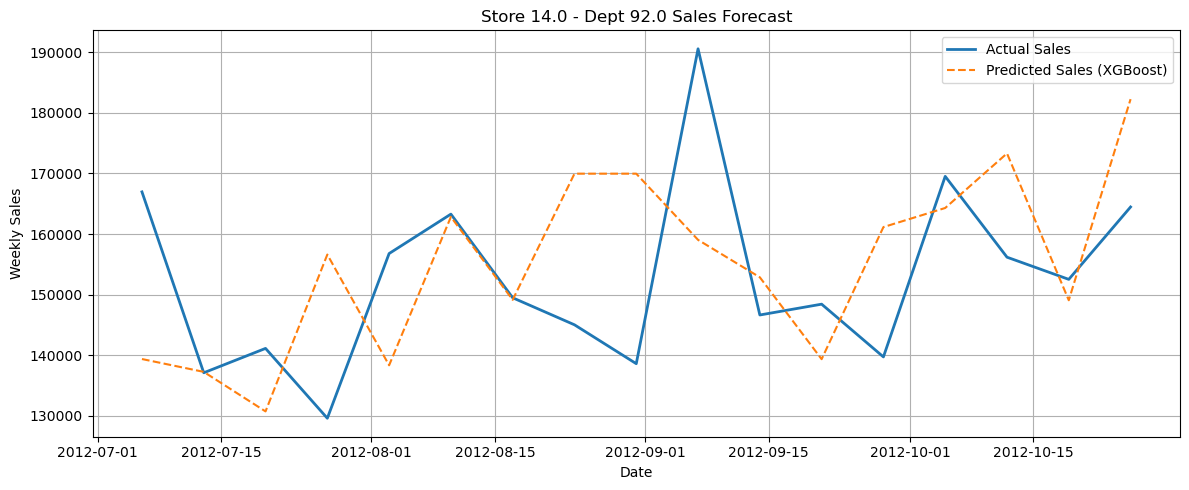

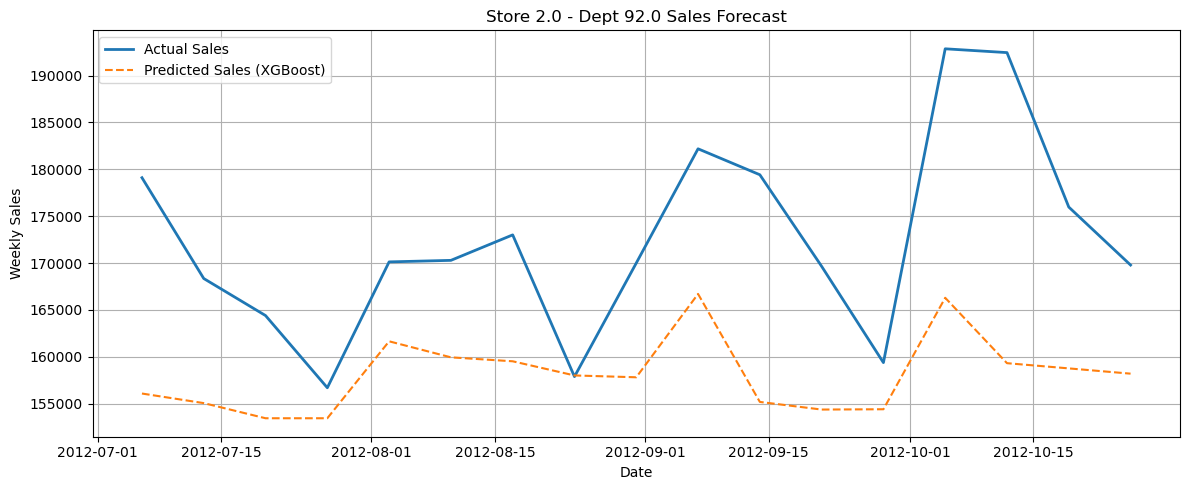

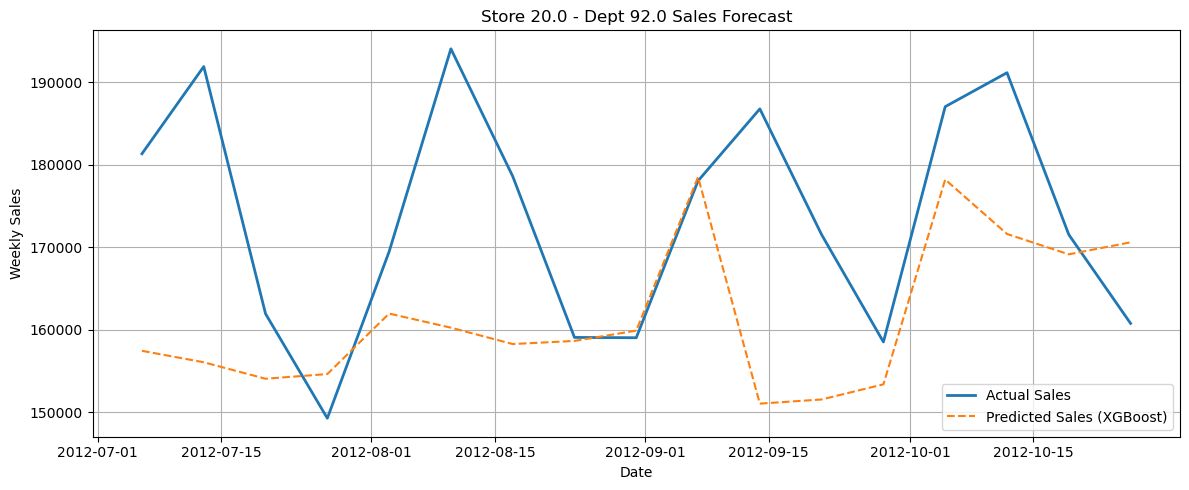

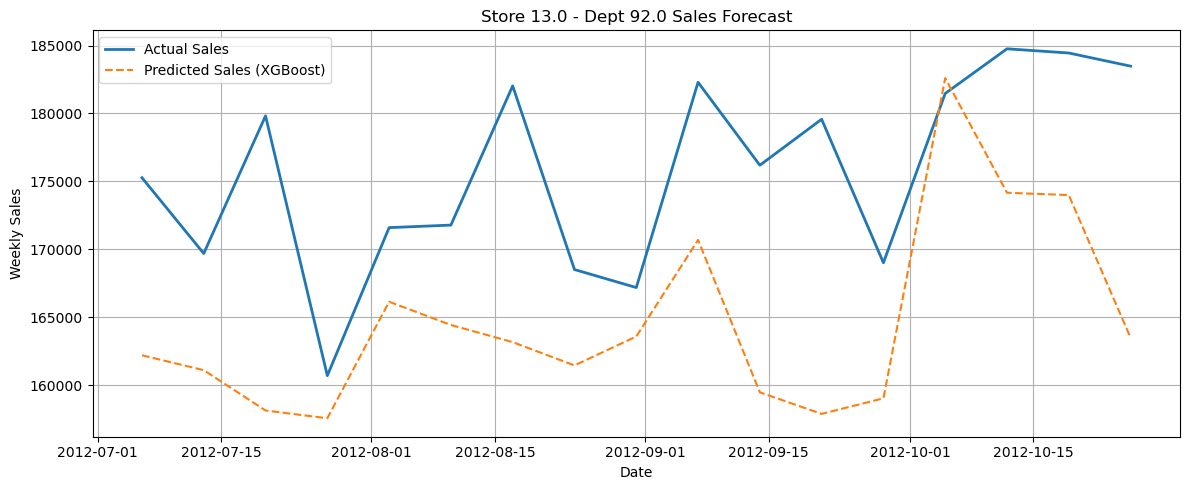

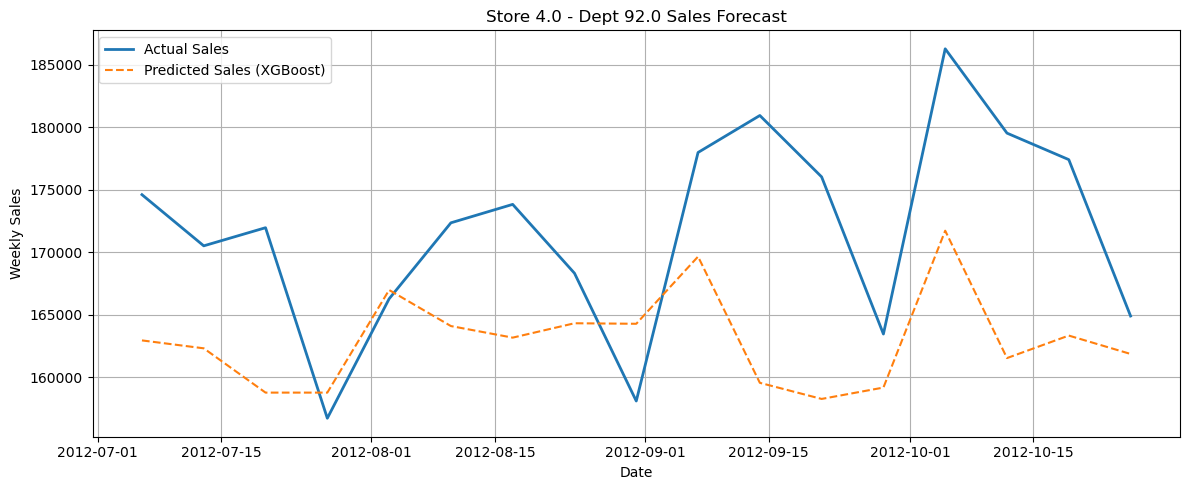

In [19]:
top_5 = top_combos.head(5)

import matplotlib.pyplot as plt

for _, row in top_5.iterrows():
    store = row['Store']
    dept = row['Dept']
    
    sample_data = comparison_df[(comparison_df['Store'] == store) & (comparison_df['Dept'] == dept)].sort_values('Date')

    plt.figure(figsize=(12, 5))
    plt.plot(sample_data['Date'], sample_data['Weekly_Sales'], label='Actual Sales', linewidth=2)
    plt.plot(sample_data['Date'], sample_data['Predicted_Sales'], label='Predicted Sales (XGBoost)', linestyle='--')
    plt.title(f'Store {store} - Dept {dept} Sales Forecast')
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


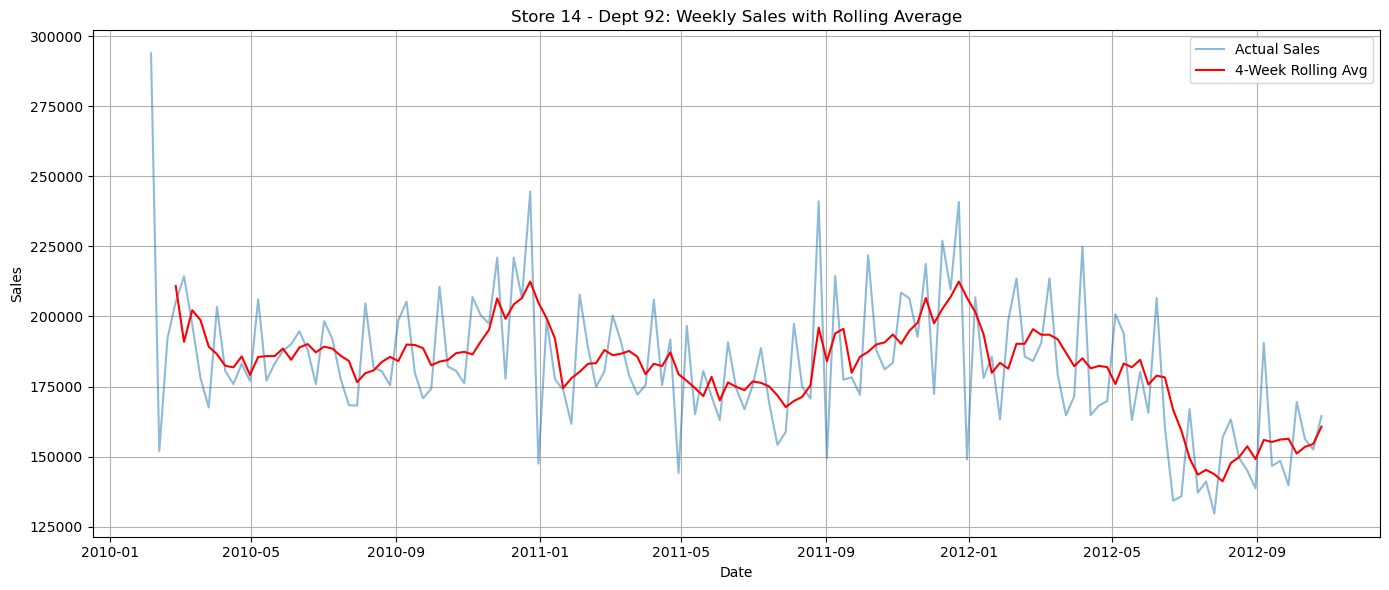

In [20]:
# Choose top store and dept (from top_5)
store = top_5.loc[0, 'Store']
dept = top_5.loc[0, 'Dept']

# Filter data
sample = df[(df['Store'] == store) & (df['Dept'] == dept)].sort_values('Date')

# Plot rolling average
plt.figure(figsize=(14, 6))
plt.plot(sample['Date'], sample['Weekly_Sales'], label='Actual Sales', alpha=0.5)
plt.plot(sample['Date'], sample['Weekly_Sales'].rolling(window=4).mean(), label='4-Week Rolling Avg', color='red')
plt.title(f'Store {store} - Dept {dept}: Weekly Sales with Rolling Average')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


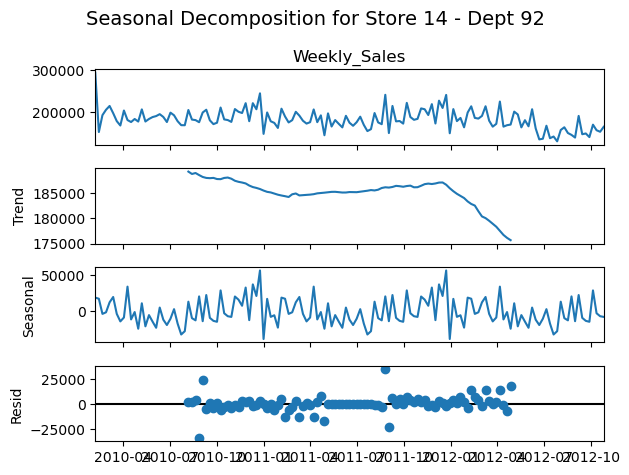

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Set index to date for decomposition
sample = sample.set_index('Date')

# Decompose (weekly frequency)
result = seasonal_decompose(sample['Weekly_Sales'], model='additive', period=52)

# Plot decomposition
result.plot()
plt.suptitle(f'Seasonal Decomposition for Store {store} - Dept {dept}', fontsize=14)
plt.tight_layout()
plt.show()
